In [2]:
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt

import mne
from mne.io import read_raw_fif, concatenate_raws
from mne.datasets import visual_92_categories

In [3]:
data_path = visual_92_categories.data_path()

# Define stimulus - trigger mapping
fname = data_path / 'visual_stimuli.csv'
conds = read_csv(fname)
print(conds.head(5))

   trigger       condition  human  face  animal  natural
0        0  human bodypart      1     0       1        1
1        1  human bodypart      1     0       1        1
2        2  human bodypart      1     0       1        1
3        3  human bodypart      1     0       1        1
4        4  human bodypart      1     0       1        1


In [3]:
conds[:48] # table with trigger and type of stimulus

trigger          condition  human  face  animal  natural
0         0     human bodypart      1     0       1        1
1         1     human bodypart      1     0       1        1
2         2     human bodypart      1     0       1        1
3         3     human bodypart      1     0       1        1
4         4     human bodypart      1     0       1        1
5         5     human bodypart      1     0       1        1
6         6     human bodypart      1     0       1        1
7         7     human bodypart      1     0       1        1
8         8     human bodypart      1     0       1        1
9         9     human bodypart      1     0       1        1
10       10     human bodypart      1     0       1        1
11       11     human bodypart      1     0       1        1
12       12         human face      1     1       1        1
13       13         human face      1     1       1        1
14       14         human face      1     1       1        1
15       15         human face      1     1       1        1
16       16         human face      1     1       1        1
17       17         human face      1     1       1        1
18       18         human face      1     1       1        1
19       19         human face      1     1       1        1
20       20         human face      1     1       1        1
21       21         human face      1     1       1        1
22       22         human face      1     1       1        1
23       23         human face      1     1       1        1
24       24  nonhuman bodypart      0     0       1        1
25       25  nonhuman bodypart      0     0       1        1
26       26  nonhuman bodypart      0     0       1        1
27       27  nonhuman bodypart      0     0       1        1
28       28  nonhuman bodypart      0     0       1        1
29       29  nonhuman bodypart      0     0       1        1
30       30  nonhuman bodypart      0     0       1        1
31       31  nonhuman bodypart      0     0       1        1
32       32  nonhuman bodypart      0     0       1        1
33       33  nonhuman bodypart      0     0       1        1
34       34  nonhuman bodypart      0     0       1        1
35       35  nonhuman bodypart      0     0       1        1
36       36      nonhuman face      0     1       1        1
37       37      nonhuman face      0     1       1        1
38       38      nonhuman face      0     1       1        1
39       39      nonhuman face      0     1       1        1
40       40      nonhuman face      0     1       1        1
41       41      nonhuman face      0     1       1        1
42       42      nonhuman face      0     1       1        1
43       43      nonhuman face      0     1       1        1
44       44      nonhuman face      0     1       1        1
45       45      nonhuman face      0     1       1        1
46       46      nonhuman face      0     1       1        1
47       47      nonhuman face      0     1       1        1

In [28]:
max_trigger = 10
conds = conds[:max_trigger] # bring the first 48 rows

In [5]:
conds

trigger       condition  human  face  animal  natural
0        0  human bodypart      1     0       1        1
1        1  human bodypart      1     0       1        1
2        2  human bodypart      1     0       1        1
3        3  human bodypart      1     0       1        1
4        4  human bodypart      1     0       1        1
5        5  human bodypart      1     0       1        1
6        6  human bodypart      1     0       1        1
7        7  human bodypart      1     0       1        1
8        8  human bodypart      1     0       1        1
9        9  human bodypart      1     0       1        1

In [4]:
conditions = []
for c in conds.values:
    cond_tags = list(c[:2])
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)]
    conditions.append('/'.join(map(str, cond_tags)))
print(conditions[:10])

['0/human bodypart/human/not-face/animal/natural', '1/human bodypart/human/not-face/animal/natural', '2/human bodypart/human/not-face/animal/natural', '3/human bodypart/human/not-face/animal/natural', '4/human bodypart/human/not-face/animal/natural', '5/human bodypart/human/not-face/animal/natural', '6/human bodypart/human/not-face/animal/natural', '7/human bodypart/human/not-face/animal/natural', '8/human bodypart/human/not-face/animal/natural', '9/human bodypart/human/not-face/animal/natural']


In [5]:
event_id = dict(zip(conditions, conds.trigger + 1))
event_id

{'0/human bodypart/human/not-face/animal/natural': 1,
 '1/human bodypart/human/not-face/animal/natural': 2,
 '2/human bodypart/human/not-face/animal/natural': 3,
 '3/human bodypart/human/not-face/animal/natural': 4,
 '4/human bodypart/human/not-face/animal/natural': 5,
 '5/human bodypart/human/not-face/animal/natural': 6,
 '6/human bodypart/human/not-face/animal/natural': 7,
 '7/human bodypart/human/not-face/animal/natural': 8,
 '8/human bodypart/human/not-face/animal/natural': 9,
 '9/human bodypart/human/not-face/animal/natural': 10,
 '10/human bodypart/human/not-face/animal/natural': 11,
 '11/human bodypart/human/not-face/animal/natural': 12,
 '12/human face/human/face/animal/natural': 13,
 '13/human face/human/face/animal/natural': 14,
 '14/human face/human/face/animal/natural': 15,
 '15/human face/human/face/animal/natural': 16,
 '16/human face/human/face/animal/natural': 17,
 '17/human face/human/face/animal/natural': 18,
 '18/human face/human/face/animal/natural': 19,
 '19/human 

In [6]:
n_runs = 4  
fnames = [data_path / f'sample_subject_{b}_tsss_mc.fif' for b in range(n_runs)]
raws = [read_raw_fif(fname, verbose='error', on_split_missing='ignore')
        for fname in fnames]  # ignore filename warnings
raw = concatenate_raws(raws)

events = mne.find_events(raw, min_duration=.002)
events

4142 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]


array([[  87422,       0,     200],
       [  90616,       0,      63],
       [  91460,       0,      66],
       ...,
       [4953219,       0,      93],
       [4953605,       0,     222],
       [4955742,       0,     244]])

In [9]:
# # i bring only the first 48 events
events = events[events[:, 2] <= max_trigger]

In [8]:
len(events)

4142

In [11]:
fnames # list of subject's raw files

[PosixPath('/home/rickbook/mne_data/MNE-visual_92_categories-data/sample_subject_0_tsss_mc.fif'),
 PosixPath('/home/rickbook/mne_data/MNE-visual_92_categories-data/sample_subject_1_tsss_mc.fif'),
 PosixPath('/home/rickbook/mne_data/MNE-visual_92_categories-data/sample_subject_2_tsss_mc.fif'),
 PosixPath('/home/rickbook/mne_data/MNE-visual_92_categories-data/sample_subject_3_tsss_mc.fif')]

In [9]:
picks = mne.pick_types(raw.info, meg=True)
picks # list of channels

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [10]:
# tmin, tmax = -0.2, 0.5 # time interval for epochs
# Start and end time of the epochs in seconds, relative to the time-locked event. The closest or 
# matching samples corresponding to the start and end time are included. Defaults to -0.2 and 0.5, 
# respectively.

epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None,
                    picks=picks, tmin=-.1, tmax=.500, preload=True)

# by defaunlt, drop the bad channels

Not setting metadata
2760 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2760 events and 601 original time points ...
2 bad epochs dropped


In [19]:
import torch
import pickle

# save the labels of the event in a pickle file

ev = epochs.events[:, 2] - 1
ev = torch.Tensor(ev)

with open('./data/visual_stimuli/events_label.pkl', 'wb') as f:
    pickle.dump(ev, f, pickle.HIGHEST_PROTOCOL)


In [34]:
print('number of events: ', len([epochs[i].get_data().shape for i in epochs.event_id]))

number of events:  10


Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching eve

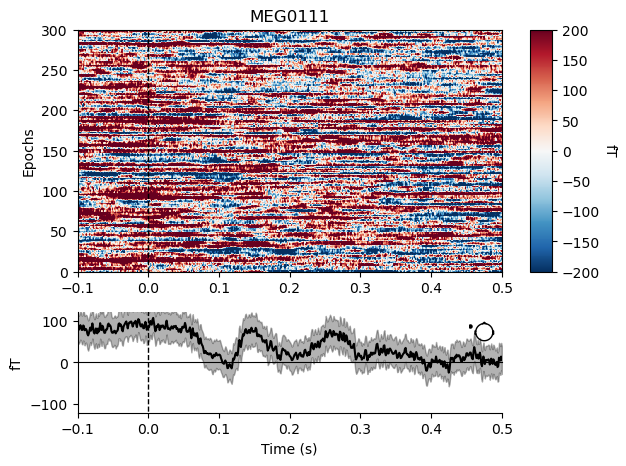

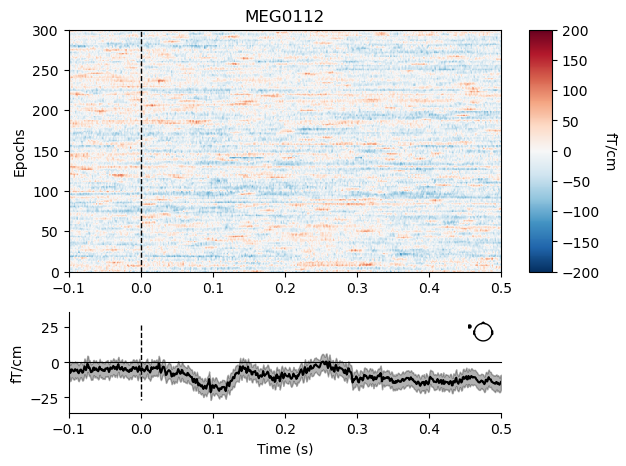

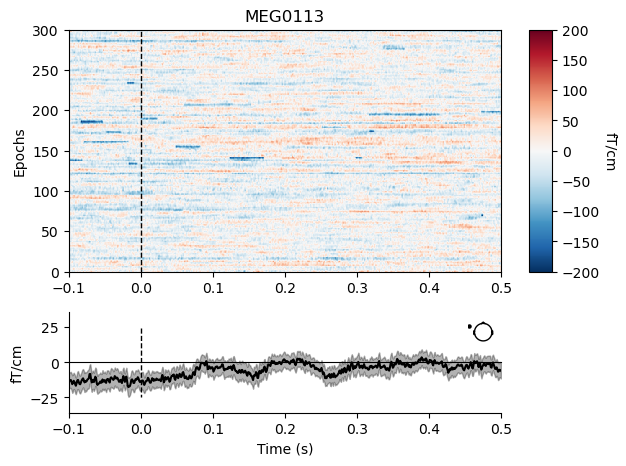

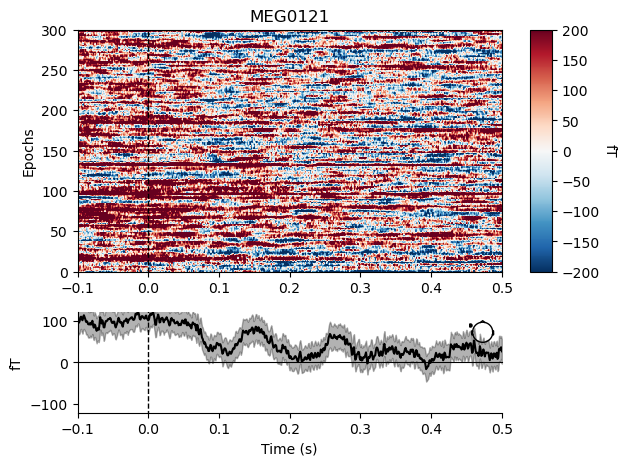

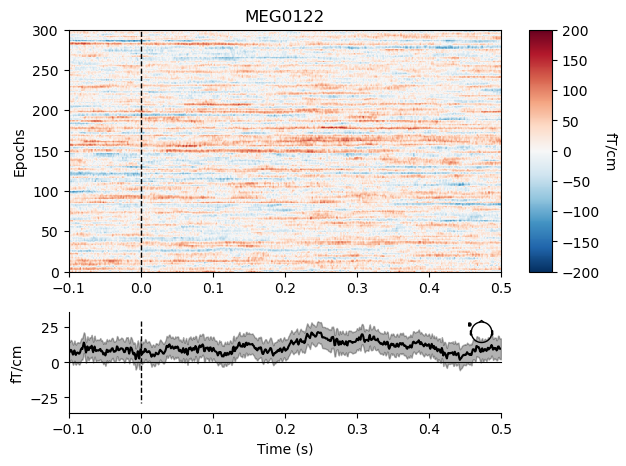

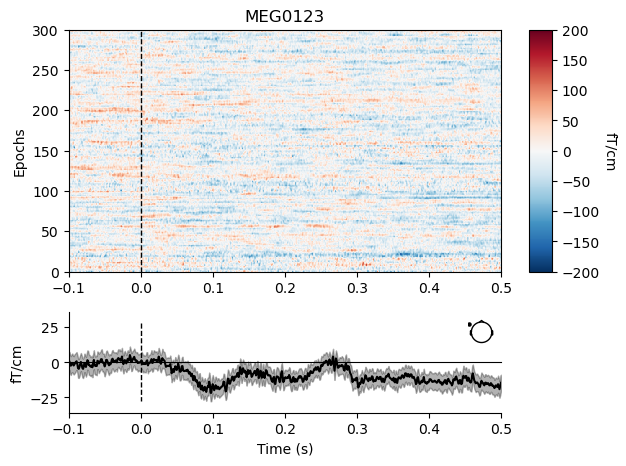

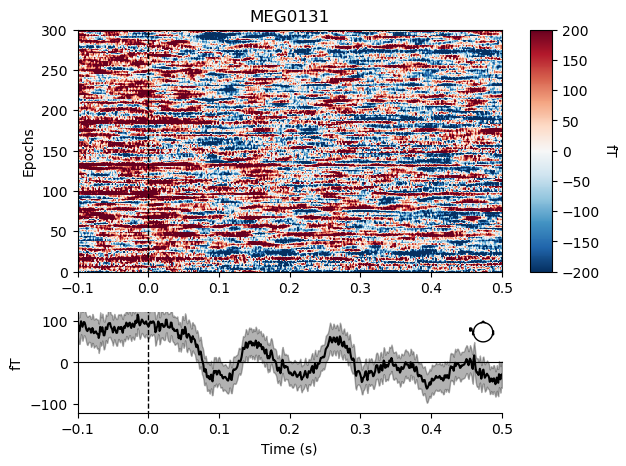

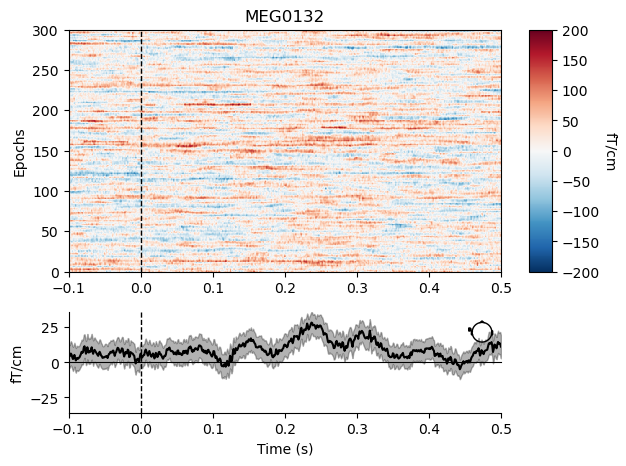

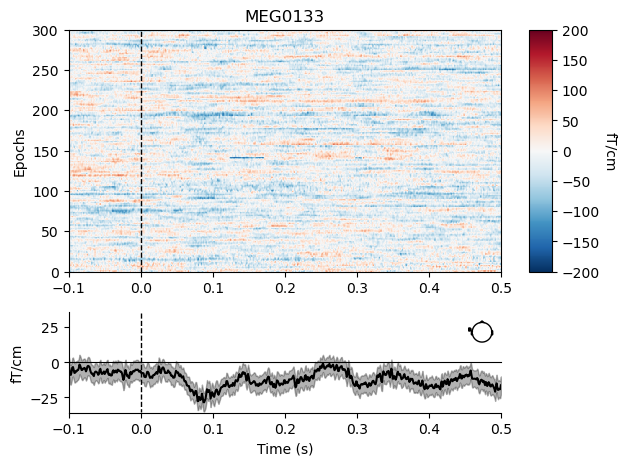

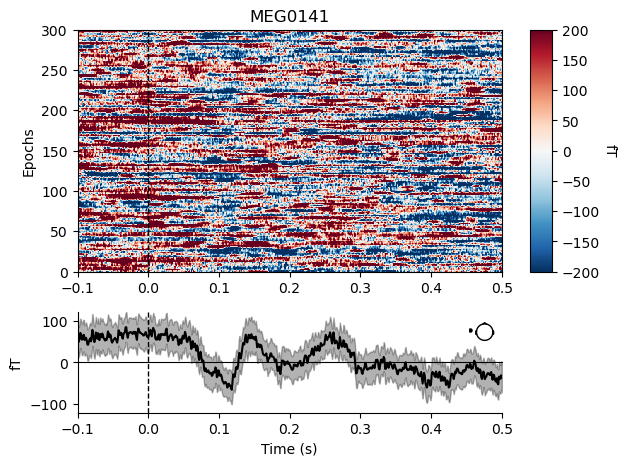

[<Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>]

In [35]:
epochs.plot_image(picks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], sigma=1., vmin=-200, vmax=200)

In [15]:
# epochs['face'].plot()

# epochs['face'].average().plot()

# epochs['face'].average().plot_topomap(times=np.linspace(.05, .45, 15), ch_type='mag')


categories:  [array([1], dtype=uint8), array([0], dtype=uint8), array([1], dtype=uint8), array([1], dtype=uint8)]


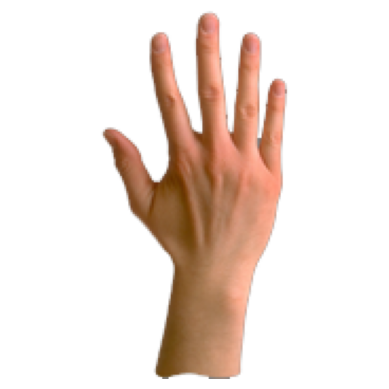

In [16]:
# visual_stimuli.mat
# The visual_stimuli.mat file which contains the images used in the experiment.

import scipy.io
mat = scipy.io.loadmat('/home/rickbook/mne_data/MNE-visual_92_categories-data/visual_stimuli.mat')

import matplotlib.pyplot as plt

plt.imshow(mat['visual_stimuli'][0][0][5])
plt.axis('off')

print('categories: ',[mat['visual_stimuli'][0][0][i][0] for i in range(1, 5, 1)])

categories:  [array([1], dtype=uint8), array([0], dtype=uint8), array([1], dtype=uint8), array([1], dtype=uint8)]


(-0.5, 174.5, 174.5, -0.5)

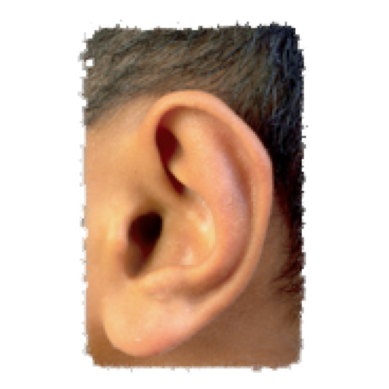

In [17]:
print('categories: ',[mat['visual_stimuli'][0][1][i][0] for i in range(1, 5, 1)])

plt.imshow(mat['visual_stimuli'][0][1][5])
plt.axis('off')

categories:  [array([1], dtype=uint8), array([0], dtype=uint8), array([1], dtype=uint8), array([1], dtype=uint8)]


(-0.5, 174.5, 174.5, -0.5)

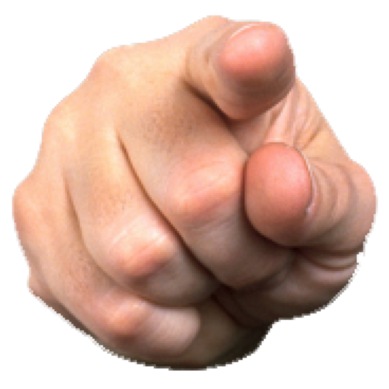

In [18]:
print('categories: ',[mat['visual_stimuli'][0][10][i][0] for i in range(1, 5, 1)])

plt.imshow(mat['visual_stimuli'][0][10][5])
plt.axis('off')

In [19]:
# raw.get_data('meg').shape

In [3]:
import scipy.io
mat = scipy.io.loadmat('/home/rickbook/mne_data/MNE-visual_92_categories-data/visual_stimuli.mat')

import pickle

with open('./visual_stimuli.pickle', 'wb') as f:
    pickle.dump(mat, f)

In [37]:
ica_epochs = epochs.copy().load_data().pick_types(meg=True, eeg=False)
method = 'fastica'
ica = mne.preprocessing.ICA(n_components=0.9, method=method, random_state=0)

# 'fastica'
# Pierre Ablin, Jean-Francois Cardoso, and Alexandre Gramfort. Faster Independent Component 
# Analysis by preconditioning with hessian approximations. 
# IEEE Transactions on Signal Processing, 66(15):4040–4049, 2018. doi:10.1109/TSP.2018.2844203.

In [38]:
ica.fit(ica_epochs)
ica.apply(ica_epochs)

Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by explained variance: 17 components
Fitting ICA took 19.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (17 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


<Epochs |  300 events (all good), -0.1 - 0.5 sec, baseline off, ~427.3 MB, data loaded,
 '0/human bodypart/human/not-face/animal/natural': 30
 '1/human bodypart/human/not-face/animal/natural': 30
 '2/human bodypart/human/not-face/animal/natural': 30
 '3/human bodypart/human/not-face/animal/natural': 30
 '4/human bodypart/human/not-face/animal/natural': 30
 '5/human bodypart/human/not-face/animal/natural': 30
 '6/human bodypart/human/not-face/animal/natural': 30
 '7/human bodypart/human/not-face/animal/natural': 30
 '8/human bodypart/human/not-face/animal/natural': 30
 '9/human bodypart/human/not-face/animal/natural': 30>

Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
300 matching eve

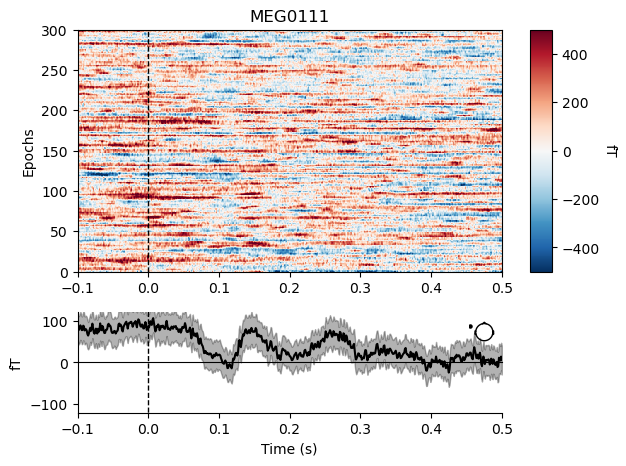

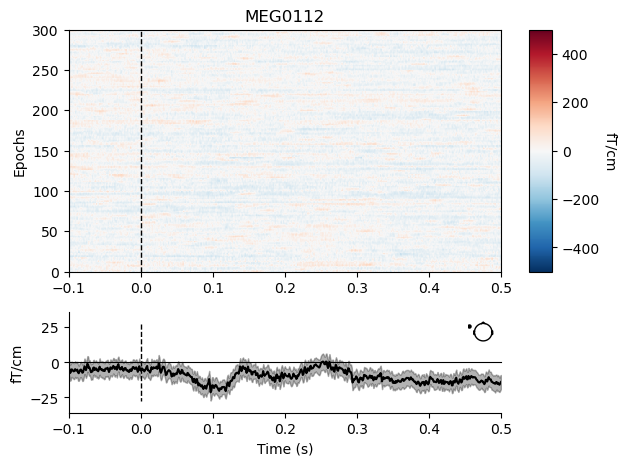

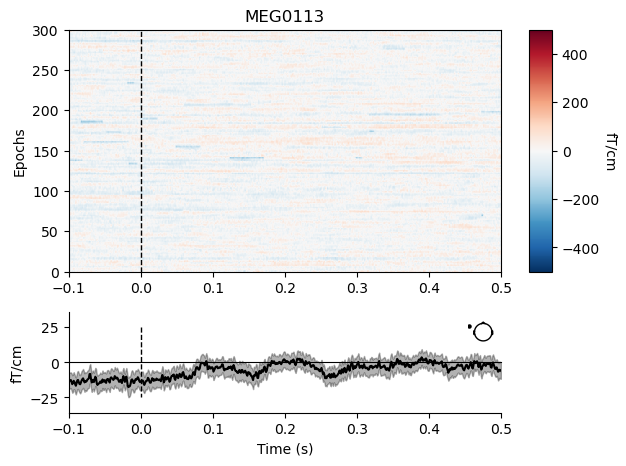

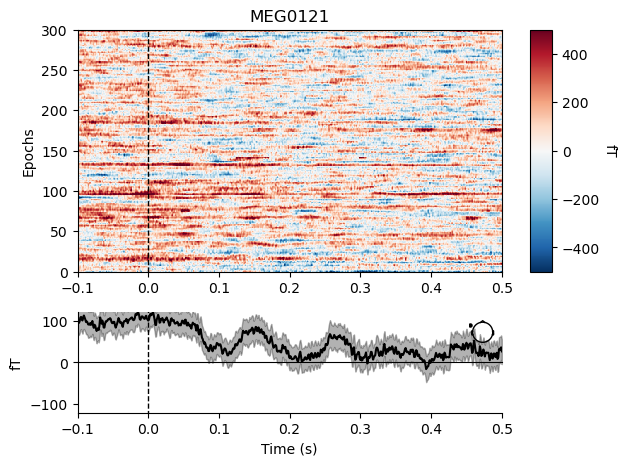

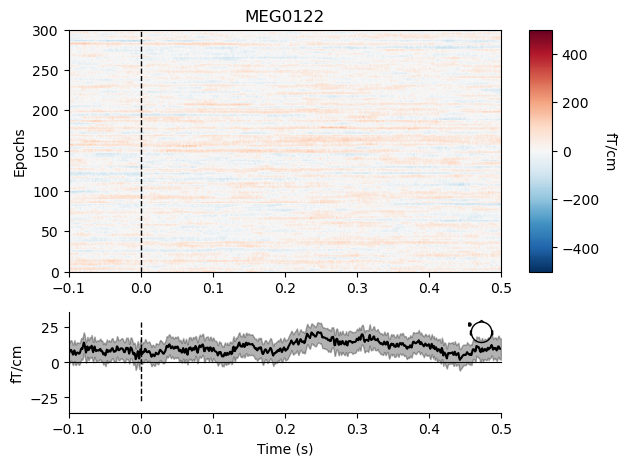

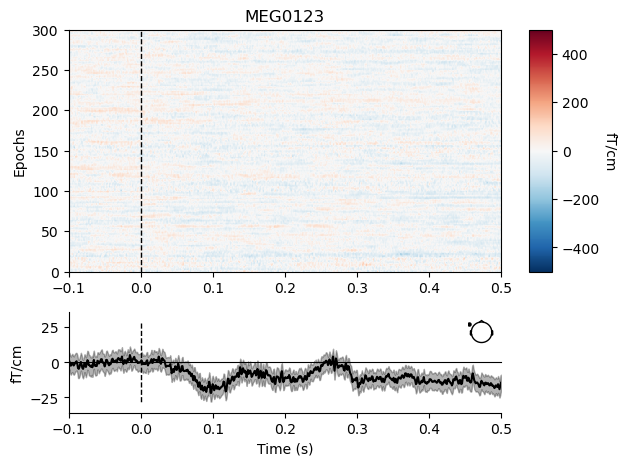

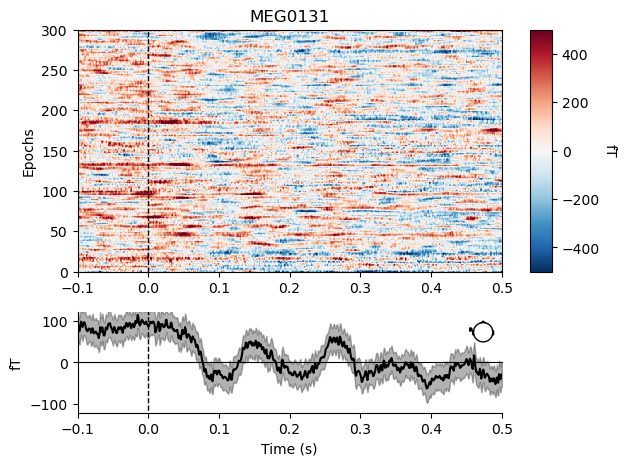

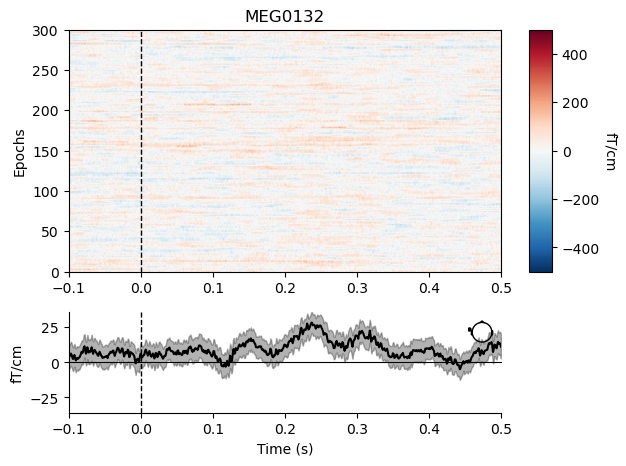

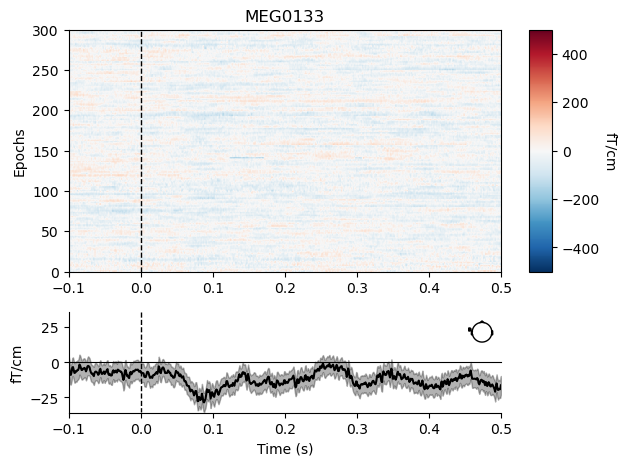

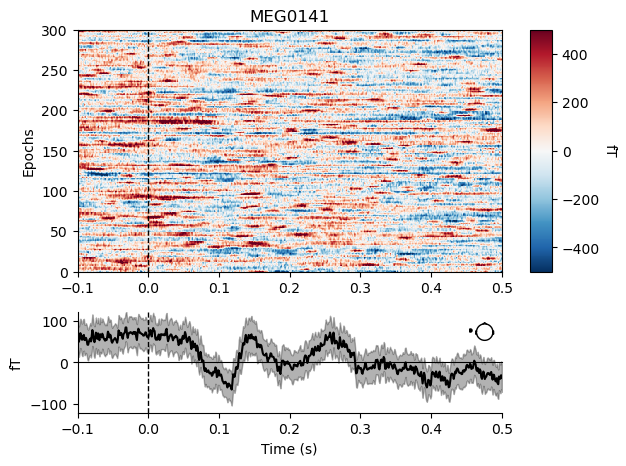

[<Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>]

In [39]:
ica_epochs.plot_image(picks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], sigma=1., vmin=-500, vmax=500)

In [18]:
# extract the data from the epochs preprocessed with ICA
# save the data in a pickle file as float32


# import pickle
# import numpy as np
# import glob

# with open(glob.glob('./data/visual_stimuli/*.pickle')[0], 'rb') as f:
#     mat = pickle.load(f)

# mat = mat.astype(np.float32)

# for file in glob.glob('./data/visual_stimuli/*.pickle')[1:]:
#     with open(file, 'rb') as f:
#         temp = pickle.load(f)

#     temp = temp.astype(np.float32)

#     mat = np.concatenate((mat, temp), axis=0)

#     print(mat.shape)


# import pickle

# with open('./data/visual_stimuli/visual_stimuli_ica_preprocessed.pickle', 'wb') as f:
#     pickle.dump(mat, f)


(629, 306, 601)
(929, 306, 601)
(1229, 306, 601)
(1529, 306, 601)
(1859, 306, 601)
(2158, 306, 601)
(2458, 306, 601)
(2758, 306, 601)
